<a href="https://colab.research.google.com/github/vibhagvijay/DS-Project/blob/main/Group_5_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a CNN Model for Image Classification**

### Project Approach

*   Our group is interested in building a convultional neural network (CNN) model to preform image classification
*   We are interested in using the keras package from tensorflow
*   Shifting from R into Python for easier tensorflow utilization
*   Initially focusing on learning and experimentation to better understand our methods through:
1.   Exploring online examples of building similar models
2.   Exploring frameworks provided by "Hands-On Convolutional Neural Networks with TensorFlow" by Zafar et. al
*   End goal: using our knowledge of image classification to build a CNN modeling based off of a graphical dataset of our choosing

### *Code walkthrough from https://www.tensorflow.org/tutorials/images/classification*

In [ ]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Downloading the flower dataset (contains five sub-directories (daisy, dandelion, roses, sunflowers, tulips), one per class)
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
# Checking how many images are in the dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


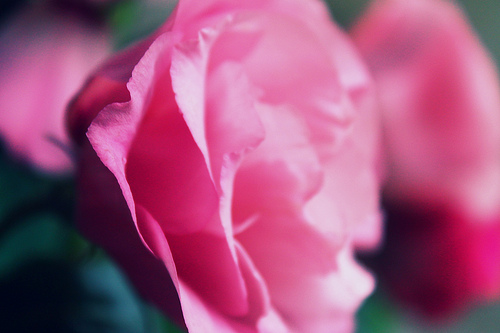

In [ ]:
# View roses in the dataset
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

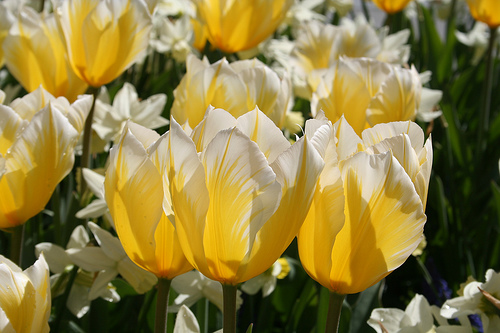

In [ ]:
# View tulips in the dataset
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [ ]:
# The next step is to loaad the images off disk using the tf.keras.utils.image_dataset_from_directory utility.
# First, define parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Splitting the data into 80% training and 20% validation
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# Splitting the data into 80% training and 20% validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# Locate the class names in the 'class_names' attribute of these datasets, corresponding with the original directory
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


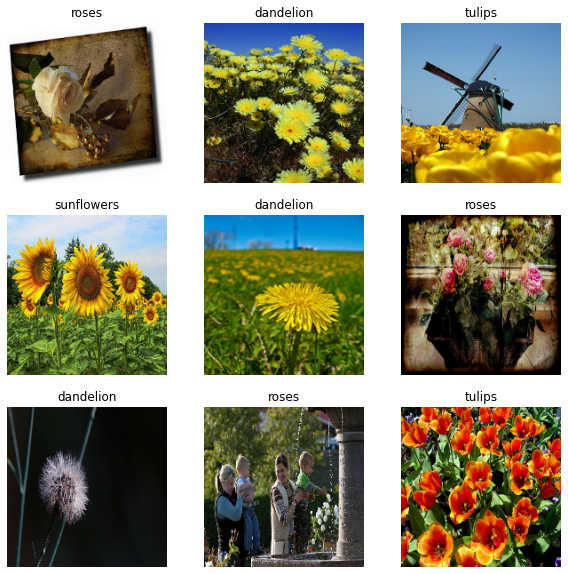

In [ ]:
# Visualize the first nine images of the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


^^^ The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

^^^ Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

*   Dataset.cache keeps the images in memory after they're loaded 
off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
*   Dataset.prefetch overlaps data preprocessing and model execution while training.

In [ ]:
# Standardize the RGB channel values to [0,1]
# This layer will be included within the model definition
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# Creating the Keras Sequential Model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

^^^ The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View all the layers of the network using the Keras Model.summary method
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# Train the model for 10 epochs with the Keras Model.fit method
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 112s 1s/step - loss: 1.3592 - accuracy: 0.3995 - val_loss: 1.0842 - val_accuracy: 0.5450
Epoch 2/10
92/92 [==============================] - 101s 1s/step - loss: 1.0390 - accuracy: 0.5790 - val_loss: 1.0870 - val_accuracy: 0.5627
Epoch 3/10
92/92 [==============================] - 101s 1s/step - loss: 0.8707 - accuracy: 0.6611 - val_loss: 0.9655 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 100s 1s/step - loss: 0.6641 - accuracy: 0.7452 - val_loss: 0.8635 - val_accuracy: 0.6689
Epoch 5/10
92/92 [==============================] - 101s 1s/step - loss: 0.4668 - accuracy: 0.8294 - val_loss: 0.9725 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 101s 1s/step - loss: 0.2876 - accuracy: 0.8948 - val_loss: 1.0450 - val_accuracy: 0.6703
Epoch 7/10
92/92 [==============================] - 98s 1s/step - loss: 0.1323 - accuracy: 0.9649 - val_loss: 1.3190 - val_accuracy: 0.6485
Epoch 8/10
92/

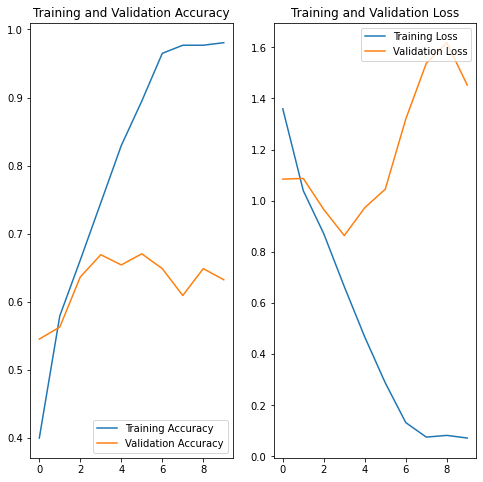

In [ ]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Above results indicate overfitting. 

In [ ]:
# Resolving overfitting with data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

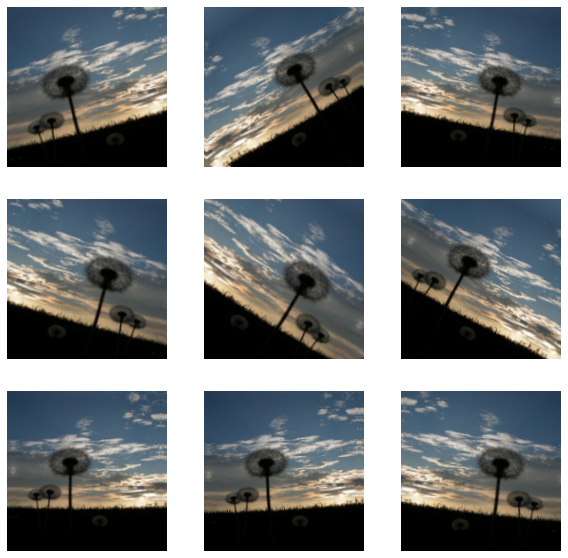

In [ ]:
# Visualize a few augmented examples by applying data augmentation to the same image several times:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Further reduce effects of overfitting using dropout technique
# Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
# Compile updated model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
# Train updated model
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 118s 1s/step - loss: 1.4290 - accuracy: 0.3750 - val_loss: 1.1635 - val_accuracy: 0.5232
Epoch 2/15
92/92 [==============================] - 115s 1s/step - loss: 1.0992 - accuracy: 0.5443 - val_loss: 1.0870 - val_accuracy: 0.5586
Epoch 3/15
92/92 [==============================] - 114s 1s/step - loss: 0.9899 - accuracy: 0.6165 - val_loss: 0.9547 - val_accuracy: 0.6294
Epoch 4/15
92/92 [==============================] - 114s 1s/step - loss: 0.8854 - accuracy: 0.6649 - val_loss: 1.0073 - val_accuracy: 0.6022
Epoch 5/15
92/92 [==============================] - 116s 1s/step - loss: 0.8423 - accuracy: 0.6737 - val_loss: 0.8230 - val_accuracy: 0.6826
Epoch 6/15
92/92 [==============================] - 115s 1s/step - loss: 0.8105 - accuracy: 0.6856 - val_loss: 0.8210 - val_accuracy: 0.6880
Epoch 7/15
92/92 [==============================] - 115s 1s/step - loss: 0.7573 - accuracy: 0.7091 - val_loss: 0.8508 - val_accuracy: 0.6621
Epoch 8/15
92

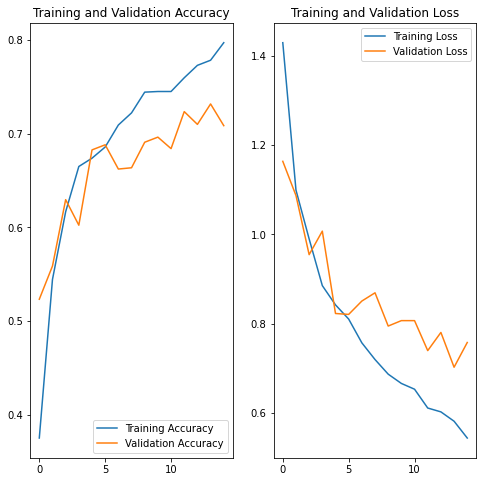

In [ ]:
# Visualize updated training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Predicting new data
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 312ms/step
This image most likely belongs to sunflowers with a 95.14 percent confidence.


### *Code walkthrough from "1.0 Convolutional Neural Network (CNN)"*

In [ ]:
#https://www.kaggle.com/code/anandhuh/image-classification-using-cnn-for-beginners/notebook
# Import TensorFlow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
#loading in the data
#The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images.
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
#creating an array to classify the categories in the dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#plotting the first 25 points in the data to make sure it looks correct
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays which is why we need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
#creating the CNN base
#As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. 
#If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), 
#which is the format of CIFAR images. You can do this by passing the argument input_shape to our first layer.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
#displaying the architecture of the model
model.summary()

In [ ]:
#To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. 
#Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. 
#First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. 
#CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
#displaying the full architecture of the model
model.summary()

In [ ]:
#Compiling and training the model
# Adam is the best among the adaptive optimizers in most of the cases
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# An epoch means training the neural network with all the
# training data for one cycle. Here I use 10 epochs
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

In [ ]:
#evaluating the model by graphing the accuracy 
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,
                                     test_labels,
                                     verbose=2)

In [ ]:
print('Test Accuracy is',test_acc)

## **Building a model from MNIST handwritten digit dataset**

**BACKGROUND**: After exploring the aformentioned resources, we want to explore the process of building a CNN model of our own. Using the keras package, we will construct, train, and test a sequential model that will intake image data in the form of 28 x 28 pixel handwritten digits and output a classsification. Our data is provided by the Modified National Institute of Standards and Technology database.

**QUESTION**: Can we construct a CNN model that can accurately classify images of handwritten digits?

### *Dataset exploration and preparation*

In [ ]:
#loading in packages and environments
import numpy as np                   
import matplotlib.pyplot as plt      
import random                        

from keras.datasets import mnist     # Loading in our dataset 
from keras.models import Sequential  # Using Sequential as our model type

from keras.layers.core import Dense, Dropout, Activation #getting the layer types
from keras.utils import np_utils     

In [ ]:
# The MNIST set is split between 60000 28x28 pixel training images and 10000 28x28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#printing the shapes of our datasets to confirm the sizes 
print("X_train ", X_train.shape)
print("y_train ", y_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
X_train  (60000, 28, 28)
y_train  (60000,)
X_test  (10000, 28, 28)
y_test  (10000,)


In [ ]:
# Partioning out 5% of the training set for a prediction set
X_pred=X_train[0:3000,0:28]
Y_pred=y_train[0:3000]

print("X_pred ",X_pred.shape)
print("Y_pred ",Y_pred.shape)

X_train=X_train[3000:60000,0:28]
y_train=y_train[3000:60000]

print("X_train ", X_train.shape)
print("y_train ", y_train.shape)

X_pred  (3000, 28, 28)
Y_pred  (3000,)
X_train  (57000, 28, 28)
y_train  (57000,)


In [ ]:
#printing just one image to see the pixels
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x): 
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

matprint(X_train[num]) #0-255 gradient color scale 0 is full black, 255 is full white

0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0   57  170  226  198  170  114   29    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0  170  255  255  255  255  255  255  226   86    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0    0  141  255  255  141   86   86   86  141  255  255   86    0    0  0  0 

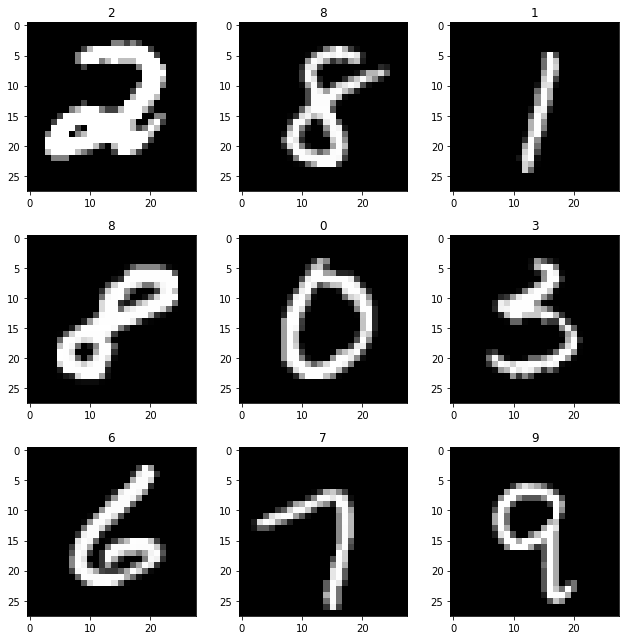

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

#plotting a matrix of random images from the dataset with their labels
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title(format(y_train[num]))
    
plt.tight_layout()

In [ ]:
X_train = X_train.reshape(57000, 784) #reshape 60,000 28 x 28 matrices into 60,000 784-length vectors (28*28)
X_test = X_test.reshape(10000, 784)   #reshape 10,000 28 x 28 matrices into 10,000 784-length vectors
X_pred=X_pred.reshape(3000,784)

#change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')
X_pred=X_pred.astype('float32')

#normalize each value for the pixel matrix 
X_train /= 255                        
X_test /= 255
X_pred /= 255

#print out the shapes for each matrix
print("training matrix shape", X_train.shape)
print("testing matrix shape", X_test.shape)
print("prediction matrix shape", X_pred.shape)

training matrix shape (57000, 784)
testing matrix shape (10000, 784)
prediction matrix shape (3000, 784)


In [ ]:
nb_classes = 10 #number of classes 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
Y_pred= np_utils.to_categorical(Y_pred, nb_classes)

###*Building, training, and testing the model*

In [ ]:
model = Sequential()

In [ ]:
#adding first layer
#512 nodes, 784 vector length (28*28)
model.add(Dense(512, input_shape=(784,)))

In [ ]:
#Using a Rectified Linear Unit (relu) as out activation function because it allows for our model to consider non linear point and interactions between the data as well
model.add(Activation('relu'))

In [ ]:
#using Dropout to make sure our model does not overfit 
model.add(Dropout(0.2))

In [ ]:
#second layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

In [ ]:
#final layer with the number of classes
model.add(Dense(10))

In [ ]:
#Using softmax as our last activation function to normalize the output of the model to probablities
model.add(Activation('softmax'))

In [ ]:
#summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

In [ ]:
# Using the adam optimizer and compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#training the model
epochs=10
history=model.fit(
          x=X_train, 
          y=Y_train,
          validation_data=(X_test, Y_test),
          batch_size=128, 
          epochs=epochs,
          verbose=1)

Epoch 1/10
446/446 [==============================] - 10s 21ms/step - loss: 0.2563 - accuracy: 0.9231 - val_loss: 0.1234 - val_accuracy: 0.9625
Epoch 2/10
446/446 [==============================] - 9s 20ms/step - loss: 0.1038 - accuracy: 0.9682 - val_loss: 0.0864 - val_accuracy: 0.9716
Epoch 3/10
446/446 [==============================] - 9s 21ms/step - loss: 0.0742 - accuracy: 0.9767 - val_loss: 0.0728 - val_accuracy: 0.9770
Epoch 4/10
446/446 [==============================] - 9s 21ms/step - loss: 0.0563 - accuracy: 0.9810 - val_loss: 0.0685 - val_accuracy: 0.9794
Epoch 5/10
446/446 [==============================] - 9s 21ms/step - loss: 0.0454 - accuracy: 0.9854 - val_loss: 0.0643 - val_accuracy: 0.9800
Epoch 6/10
446/446 [==============================] - 9s 20ms/step - loss: 0.0395 - accuracy: 0.9868 - val_loss: 0.0651 - val_accuracy: 0.9809
Epoch 7/10
446/446 [==============================] - 9s 21ms/step - loss: 0.0335 - accuracy: 0.9890 - val_loss: 0.0608 - val_accuracy: 0.983

### *Visualizing and evaluating the model*

In [ ]:
#evaluating the accuracy using test
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.0743 - accuracy: 0.9814
Test score: 0.07431573420763016
Test accuracy: 0.9814000129699707


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#Convert one-hot to index
Ypred = np.argmax(Y_pred, axis=1) 
ypred_pred = np.argmax(model.predict(X_pred), axis=-1)
print(classification_report(Ypred, ypred_pred))

94/94 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.98      0.99      0.99       339
           2       0.98      0.96      0.97       299
           3       0.98      0.97      0.97       295
           4       0.98      0.99      0.99       325
           5       0.97      0.97      0.97       274
           6       0.99      0.99      0.99       306
           7       0.97      0.99      0.98       329
           8       0.98      0.97      0.98       261
           9       0.98      0.97      0.97       287

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
# Formatting arrays of predicted and expected values
predicted = np.argmax(model.predict(X_pred),axis=1)
expected = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 1s 7ms/step


In [ ]:
# Building the confusion matrix
import sklearn.metrics
conf_matrix=sklearn.metrics.confusion_matrix(expected, predicted)

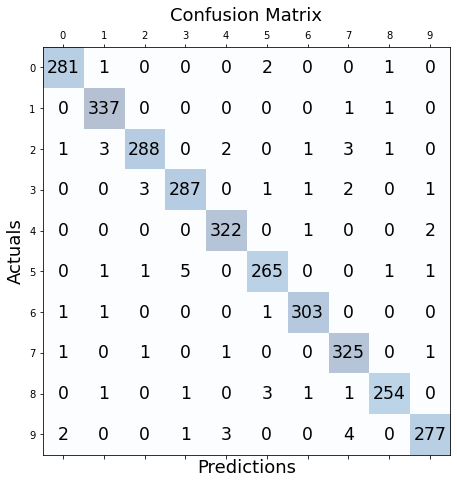

In [ ]:
#Visualizing the confusion matrix
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

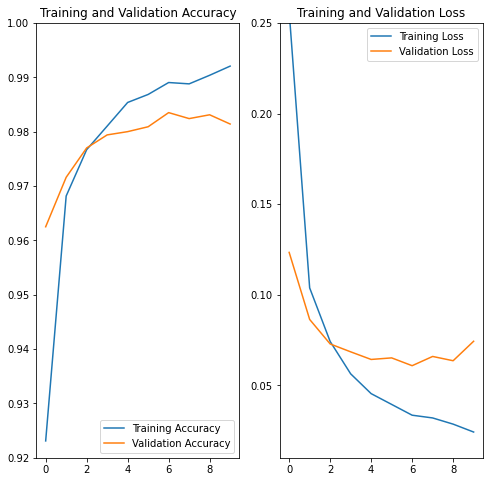

In [ ]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(0.92, 1.0)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0.01, 0.25)

plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
d = {'epoch': [1, 2,3,4,5,6,7,8,9,10], 'Training accuracy': acc, 'Training loss':loss, 'Test accuracy':val_acc, 'Test loss': val_loss}
df = pd.DataFrame(data=d)
fig = px.line(df, x='epoch', 
              y=["Training accuracy","Test accuracy"],
              markers=True,
              width=800,
              height=600,
              title="Training and Validation Accuracy",
              labels={
                    "variable":""
                 })
fig.show()

In [ ]:
fig2 = px.line(df, x='epoch', 
              y=["Training loss","Test loss"],
              markers=True,
              width=800,
              height=600,
              title="Training and Validation Loss",
              labels={
                    "variable":""
                 })
fig2.show()

### *Adding convultional layers*

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

model = Sequential()                                 # Linear stacking of layers
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), 
          activation='relu', 
          input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), 
          activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, 
          activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, 
          activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
history2 = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 315s 671ms/step - loss: 0.1371 - accuracy: 0.9583 - val_loss: 0.0399 - val_accuracy: 0.9870
Epoch 2/10
469/469 [==============================] - 313s 667ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0350 - val_accuracy: 0.9881
Epoch 3/10
469/469 [==============================] - 312s 665ms/step - loss: 0.0286 - accuracy: 0.9911 - val_loss: 0.0309 - val_accuracy: 0.9901
Epoch 4/10
469/469 [==============================] - 308s 657ms/step - loss: 0.0212 - accuracy: 0.9930 - val_loss: 0.0355 - val_accuracy: 0.9889
Epoch 5/10
469/469 [==============================] - 309s 659ms/step - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.0327 - val_accuracy: 0.9907
Epoch 6/10
469/469 [==============================] - 309s 659ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0341 - val_accuracy: 0.9907
Epoch 7/10
469/469 [==============================] - 309s 659ms/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0297 -

In [ ]:
from tensorflow.keras.layers import BatchNormalization

### *Sources* 

1. https://learning.oreilly.com/library/view/hands-on-convolutional-neural/9781789130331/
2. https://www.tensorflow.org/tutorials/images/classification
3. https://keras.io/examples/vision/image_classification_from_scratch/ https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb 
4. https://github.com/yashk2810/MNIST-Keras/blob/master/.ipynb_checkpoints/MNIST_keras_CNN-checkpoint.ipynb 
5. https://github.com/yashk2810/MNIST-Keras/blob/master/.ipynb_checkpoints/MNIST_keras-checkpoint.ipynb